# Classification using the CART Algorithm (a decision tree classifier) and the Gini Impurity Splitting Criterion

| Key              | Value                                                                                                                                                                                                                                                                                      |
|:-----------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Course Codes** | BBT 4106, BCM 3104, and BFS 4102                                                                                                                                                                                                                                                           |
| **Course Names** | BBT 4106: Business Intelligence I (Week 10-12 of 13),<br/>BCM 3104: Business Intelligence and Data Analytics (Week 10-12 of 13) and<br/>BFS 4102: Advanced Business Data Analytics (Week 4-6 of 13)                                                                                        |
| **Semester**     | April to July 2025                                                                                                                                                                                                                                                                         |
| **Lecturer**     | Allan Omondi                                                                                                                                                                                                                                                                               |
| **Contact**      | aomondi@strathmore.edu                                                                                                                                                                                                                                                                     |
| **Note**         | The lecture contains both theory and practice.<br/>This notebook forms part of the practice.<br/>It is intended for educational purposes only.<br/>Recommended citation: [BibTex](https://github.com/course-files/RegressionAndClassification/raw/refs/heads/main/RecommendedCitation.bib) |


**Business context**: A business has a strategic objective to *reduce customer churn to 10% by the end of the current financial year*. The lagging KPI in the customer perspective of the business' performance is the churn rate whereas its leading KPI is the number of support calls. The business would like to predict whether a customer will renew their subscription so that the marketing and sales teams can intervene early and avoid losing customers.

**Dataset**: The synthetic (not real) dataset used in this notebook is based on the **"Subscription Churn"** dataset. It contains 1,000 observations of customer data with the following features and target.

| **Type**    | **Name**        | **Description**                                                                                       |
|:------------|-----------------|:------------------------------------------------------------------------------------------------------|
| **Feature** | `monthly_fee`   | Monthly fee paid by the customer                                                                      |
| **Feature** | `customer_age`  | Age of the customer in years                                                                          |
| **Feature** | `support_calls` | Number of support calls made by the customer                                                          |
| **Target**  | `renew`         | A categorical variable that indicates if the customer renewed (1) or cancelled (0) their subscription |

## Step 1: Import the necessary libraries

**Purpose**: This chunk imports all the necessary libraries for data analysis, machine learning, and visualization.

1. **For data manipulation - [pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html):**
    - `pandas as pd`: For loading the dataset, creating and managing DataFrames, data manipulation and analysis using DataFrames

2. **For statistical data analysis - [scipy.stats](https://docs.scipy.org/doc/scipy/tutorial/stats.html)**
    - `kurtosis`: Measures the "tailedness" of data distribution
    - `skew`: Measures the asymmetry of data distribution

3. **For Machine Learning - [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html)**
    - `DecisionTreeClassifier`: A class from scikit-learn that implements the CART (Classification and Regression Trees) algorithm for building decision tree models.
    - `plot_tree`: A function from scikit-learn’s tree module that visualizes the decision tree structure.
    - `train_test_split`: A function from scikit-learn’s model_selection module that splits the dataset into training and testing sets.
    - `classification_report`: A function from scikit-learn’s metrics module used to evaluate the performance of the classifier. It gives detailed metrics such as precision, recall, f1-score, and support for each class.
    - `confusion_matrix`: A function from scikit-learn’s metrics module that computes the confusion matrix to evaluate the accuracy of a classification.
    - `GridSearchCV`: For hyperparameter tuning using cross-validation

4. **For data visualization - [matplotlib](https://matplotlib.org/stable/gallery/index.html) and [seaborn](https://seaborn.pydata.org/examples/index.html)**
    - `matplotlib.pyplot as plt`: For basic plotting functionality
    - `seaborn as sns`: For enhanced statistical visualizations

5. **For suppressing warnings - [warnings](https://docs.python.org/3/library/warnings.html)**
    - `warnings`: Controls warning messages
    - `warnings.filterwarnings('ignore')`: Suppresses warning messages for cleaner output
    - Used to suppress warnings that may arise during the execution of the code. Even though it is not necessary for the code to run, it helps in keeping the output clean and focused on the results.

In [1]:
# For File and system operations
import urllib.request
import os

# For data manipulation
import pandas as pd

# For statistical data analysis
from scipy.stats import kurtosis
from scipy.stats import skew

# For Machine Learning
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For model persistence
import joblib

# For suppressing warnings
import warnings
warnings.filterwarnings('ignore')

## Step 2: Load and Explore the Data

**Purpose:** This chunk loads the dataset from a specified source (local file, Google Drive, or URL) into a Pandas DataFrame for further analysis.

1. **URL Configuration**
    - This specifies the location of the dataset to be loaded. You should **choose one** of the following options:
        - **From your computer**: Uncomment the line with the local path to load the dataset from your local machine.
        - **From your Google Drive using Google Colab**: Uncomment the lines to mount your Google Drive and specify the path to the dataset in your Google Drive.
        - **From a URL on GitHub**: This is the default choice. Uncomment the line with the URL to load the dataset directly from a GitHub repository.

2. **Data Loading Parameters**
    - Uses `pd.read_csv()` with specific parameters:
        - `usecols`: Loads only the columns specified in `use_cols` for memory efficiency
        - `encoding='utf-8'`: Handles special characters in the dataset. This is suitable for most languages and special characters like ñ, €, ®. Other alternative encodings include:
        - `encoding='utf-16'`: Supports multilingual characters, uses 2 Bytes per character.
        - `encoding='utf-32'`: Like utf-16 but uses 4 Bytes per character, suitable for full Unicode range.
        - `encoding='latin-1'`: Handles Western European characters (ISO-8859-1), such as ñ, ß, € without throwing decode errors.
        - `encoding='big5'`: Traditional Chinese encoding used in Taiwan and Hong Kong.
        - `encoding='shift_jis'`: Japanese character encoding used on Windows.
        - You can try different encodings if you encounter the `UnicodeDecodeError` while reading a file. This is useful in cases where the business has branches across different countries and the dataset contains characters from multiple languages.
        - `nrows=200000`: Limits the number of rows loaded to 200,000. This can be reduced or increased based on the available memory and the size of the dataset.
    - The data is then stored in a `Pandas` DataFrame for further analysis
    - This selective loading approach helps manage memory usage and focuses the analysis on the relevant features for the design of the model.

In [2]:
dataset_path = './data/subscription_churn.csv'
url = 'https://raw.githubusercontent.com/course-files/RegressionAndClassification/refs/heads/main/data/subscription_churn.csv'

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    if not os.path.exists('./data'):
        os.makedirs('./data')
    urllib.request.urlretrieve(url, dataset_path)
    print("✅ Dataset downloaded")
else:
    print("✅ Dataset already exists locally")

use_cols = ['monthly_fee','customer_age','support_calls','renew']
subscription_churn_data = pd.read_csv(dataset_path, usecols=use_cols, encoding='utf-8', nrows=200000)

✅ Dataset downloaded


### Identify the numeric and categorical columns

**Selection of numeric columns**
- The code identifies columns with numeric data types (`int64` and `float64`) that can be subjected to mathematical or statistical functions.
- The code also identifies non-numeric columns (e.g., `strings`, `objects`, etc.) by excluding numeric (`int64`, `float64`) and `datetime` data types.
- This is done using `select_dtypes()` method of the DataFrame, which filters columns based on their data types.

In [3]:
numeric_cols = subscription_churn_data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = subscription_churn_data.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns

print("\nThe identified numeric columns are:")
print(numeric_cols.tolist())

print("\nThe identified categorical columns are:")
print(categorical_cols.tolist())


The identified numeric columns are:
['monthly_fee', 'customer_age', 'support_calls', 'renew']

The identified categorical columns are:
[]


## Step 3: Initial Exploratory Data Analysis (EDA)

In [4]:
print("\n*1* The number of observations and variables")
display(subscription_churn_data.shape)

print("\n*2* The data types:")
display(subscription_churn_data.info())

print("\n*3* The summary of the numeric columns:")
display(subscription_churn_data.describe())

print("\n*4* The whole dataset:")
display(subscription_churn_data)

print("\n*5* The first 5 rows in the dataset:")
display(subscription_churn_data.head())

print("\n*6* Percentage distribution for each category")
print("\nNumber of observations per class:")
print("Frequency counts:\n", subscription_churn_data['renew'].value_counts())
print("\nPercentages:\n", subscription_churn_data['renew'].value_counts(normalize=True) * 100, "%")


*1* The number of observations and variables


(1000, 4)


*2* The data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   monthly_fee    1000 non-null   float64
 1   customer_age   1000 non-null   float64
 2   support_calls  1000 non-null   int64  
 3   renew          1000 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 31.4 KB


None


*3* The summary of the numeric columns:


,monthly_fee,customer_age,support_calls,renew
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,50.193260,35.708800,0.946000,0.794000
std,9.792202,9.973069,0.983896,0.404633
min,17.590000,5.600000,0.000000,0.000000
25%,43.520000,28.900000,0.000000,1.000000
50%,50.255000,35.600000,1.000000,1.000000
75%,56.482500,42.300000,1.000000,1.000000
max,88.530000,66.900000,6.000000,1.000000



*4* The whole dataset:


,monthly_fee,customer_age,support_calls,renew
0,54.97,49.0,1,1
1,48.62,44.2,0,1
2,56.48,35.6,0,1
3,65.23,28.5,2,1
4,47.66,42.0,2,1
...,...,...,...,...
995,47.19,45.7,1,0
996,67.98,34.7,1,1
997,56.41,26.2,0,1
998,44.29,33.4,2,1



*5* The first 5 rows in the dataset:


,monthly_fee,customer_age,support_calls,renew
0,54.97,49.0,1,1
1,48.62,44.2,0,1
2,56.48,35.6,0,1
3,65.23,28.5,2,1
4,47.66,42.0,2,1



*6* Percentage distribution for each category

Number of observations per class:
Frequency counts:
 renew
1    794
0    206
Name: count, dtype: int64

Percentages:
 renew
1    79.4
0    20.6
Name: proportion, dtype: float64 %


### Measures of Distribution

#### Variance of numeric columns

In [5]:
print("\nVariance of the numeric columns:")
print(subscription_churn_data[numeric_cols].var())


Variance of the numeric columns:
monthly_fee      95.887227
customer_age     99.462105
support_calls     0.968052
renew             0.163728
dtype: float64


#### Standard deviation of numeric columns

In [6]:
print("\nStandard deviation of the numeric columns:")
print(subscription_churn_data[numeric_cols].std())


Standard deviation of the numeric columns:
monthly_fee      9.792202
customer_age     9.973069
support_calls    0.983896
renew            0.404633
dtype: float64


#### Kurtosis of numeric columns

In [7]:
print("\nFisher Kurtosis of numeric columns:")
print("\nInterpretation:")
print("→ Positive kurtosis indicates heavier tails (more outliers) than what is expected in a normal distribution - leptokurtic")
print("→ Negative kurtosis indicates lighter tails (less outliers) than what is expected in a normal distribution - platykurtic")
print("→ A normal distribution has kurtosis of 0 - mesokurtic")
print("\nKurtosis values:")
print(subscription_churn_data[numeric_cols].apply(lambda x: kurtosis(x, fisher=True)))


Fisher Kurtosis of numeric columns:

Interpretation:
→ Positive kurtosis indicates heavier tails (more outliers) than what is expected in a normal distribution - leptokurtic
→ Negative kurtosis indicates lighter tails (less outliers) than what is expected in a normal distribution - platykurtic
→ A normal distribution has kurtosis of 0 - mesokurtic

Kurtosis values:
monthly_fee      0.066182
customer_age     0.051692
support_calls    1.463537
renew            0.113815
dtype: float64


#### Skewness of numeric columns

In [8]:
print("\nSkewness of numeric columns:")
print("\nInterpretation:")
print("→ Positive skewness indicates a long right tail (right-skewed distribution)")
print("→ Negative skewness indicates a long left tail (left-skewed distribution)")
print("→ Skewness close to 0 indicates a symmetric distribution")
print("\nSkewness values:")
print(subscription_churn_data[numeric_cols].apply(lambda x: skew(x)))


Skewness of numeric columns:

Interpretation:
→ Positive skewness indicates a long right tail (right-skewed distribution)
→ Negative skewness indicates a long left tail (left-skewed distribution)
→ Skewness close to 0 indicates a symmetric distribution

Skewness values:
monthly_fee      0.116778
customer_age    -0.049081
support_calls    1.136473
renew           -1.453896
dtype: float64


### Measures of Relationship

#### Covariance matrix of numeric features

In [9]:
print("\nCovariance matrix of numeric features:")
print("\nInterpretation:")
print("→ Positive values indicate that variables move in the same direction")
print("→ Negative values indicate that variables move in opposite directions")
print("→ Values close to 0 indicate little to no linear relationship")
print("\nCovariance values:")
display(subscription_churn_data[numeric_cols].cov())


Covariance matrix of numeric features:

Interpretation:
→ Positive values indicate that variables move in the same direction
→ Negative values indicate that variables move in opposite directions
→ Values close to 0 indicate little to no linear relationship

Covariance values:


,monthly_fee,customer_age,support_calls,renew
monthly_fee,95.887227,-3.945199,0.081137,0.587809
customer_age,-3.945199,99.462105,-0.069594,-0.408195
support_calls,0.081137,-0.069594,0.968052,-0.113237
renew,0.587809,-0.408195,-0.113237,0.163728


#### Correlation matrix of numeric features

In [10]:
print("\nSpearman's rank correlation matrix of numeric features:")
spearman_corr = subscription_churn_data[numeric_cols].corr(method='spearman')
print("\nInterpretation:")
print("→ Values range from -1 to +1")
print("→ +1 indicates perfect positive correlation")
print("→ -1 indicates perfect negative correlation")
print("→ 0 indicates no correlation")
print("\nCorrelation values:")
display(spearman_corr)


Spearman's rank correlation matrix of numeric features:

Interpretation:
→ Values range from -1 to +1
→ +1 indicates perfect positive correlation
→ -1 indicates perfect negative correlation
→ 0 indicates no correlation

Correlation values:


,monthly_fee,customer_age,support_calls,renew
monthly_fee,1.000000,-0.063714,0.008833,0.134721
customer_age,-0.063714,1.000000,-0.013784,-0.092670
support_calls,0.008833,-0.013784,1.000000,-0.244082
renew,0.134721,-0.092670,-0.244082,1.000000


### Basic visualization of the data

- `n_cols = 3` Sets the number of plots per row to 3
- `n_rows = (len(numeric_cols) // n_cols) + (1 if len(numeric_cols) % n_cols else 0)` Calculates the number of rows needed based on the number of numeric columns and the number of columns per row.
- `plt.figure(figsize=(12, 5 * n_rows))` Sets the figure size to be wider and taller based on the number of rows.
- `for i, col in enumerate(numeric_cols, 1):` Iterates over each numeric column (`numeric_cols`), starting the index at 1. `enumerate(numeric_cols, 1)` returns pairs of (index, value) for each item in the list. The 1 means that the index will start from 1, e.g., (1, 'X1'), (2, 'X2'), etc.
- `plt.subplot(n_rows, n_cols, i)` Creates a subplot in a grid layout with `n_rows` rows and `n_cols` columns, placing the current plot in the `i`-th position.
- `sns.histplot(data=profit_per_product, x=col)` Plots a histogram for the current numeric column using Seaborn's `histplot` function.
- `sns.boxplot(data=profit_per_product, y=col)` Plots a box plot for the current numeric column using Seaborn's `boxplot` function.
- `sns.despine(right=True, top=True)` Removes the right and top spines (borders) of the plot for a cleaner look.
- `plt.title(f'Distribution of {col}')` Sets the title of the current subplot to indicate which column's distribution is being shown.
- `plt.grid(axis='y', alpha=0.2)` Adds a grid to the y-axis with a transparency level of 0.2 for better visibility.
- `plt.grid(axis='x', visible=False)` Hides the grid for the x-axis to reduce clutter and increase the data-to-ink ratio.
- `plt.tight_layout()` Adjusts the spacing between subplots to prevent overlap and ensure a clean layout.
- `plt.show()` Displays the entire figure with all subplots.

#### Histograms

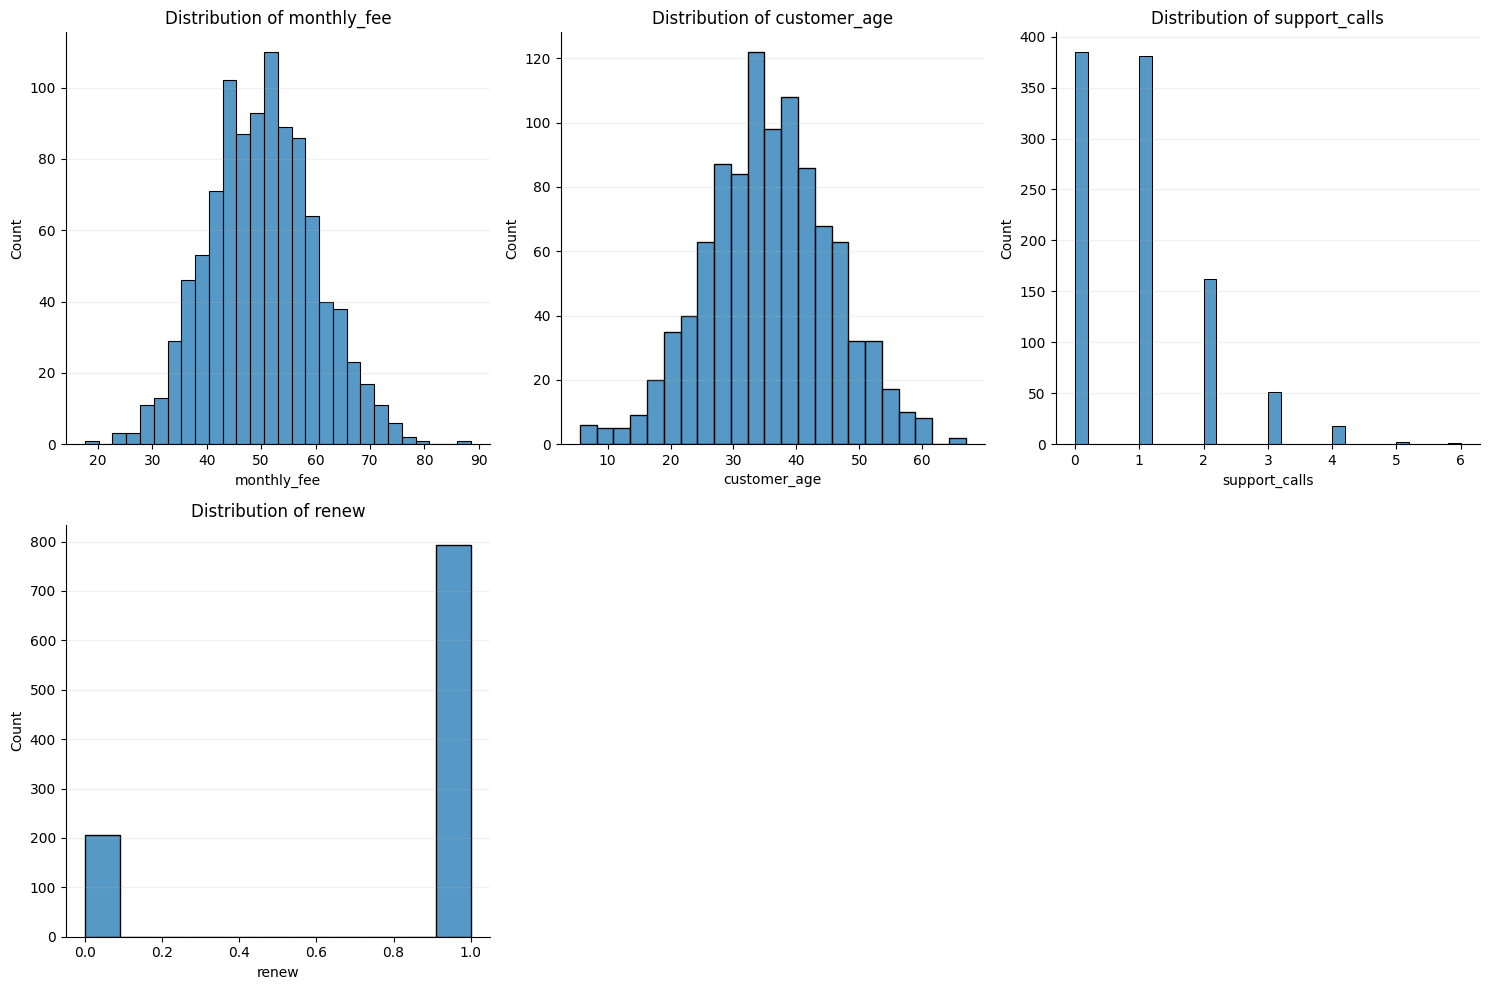

In [11]:
n_cols = 3
n_rows = (len(numeric_cols) // n_cols) + (1 if len(numeric_cols) % n_cols else 0)

plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=subscription_churn_data, x=col)
    sns.despine(right=True, top=True)
    plt.title(f'Distribution of {col}')
    plt.grid(axis='y', alpha=0.2)
    plt.grid(axis='x', visible=False)
plt.tight_layout()  # Adjust spacing
plt.show()

#### Box plots

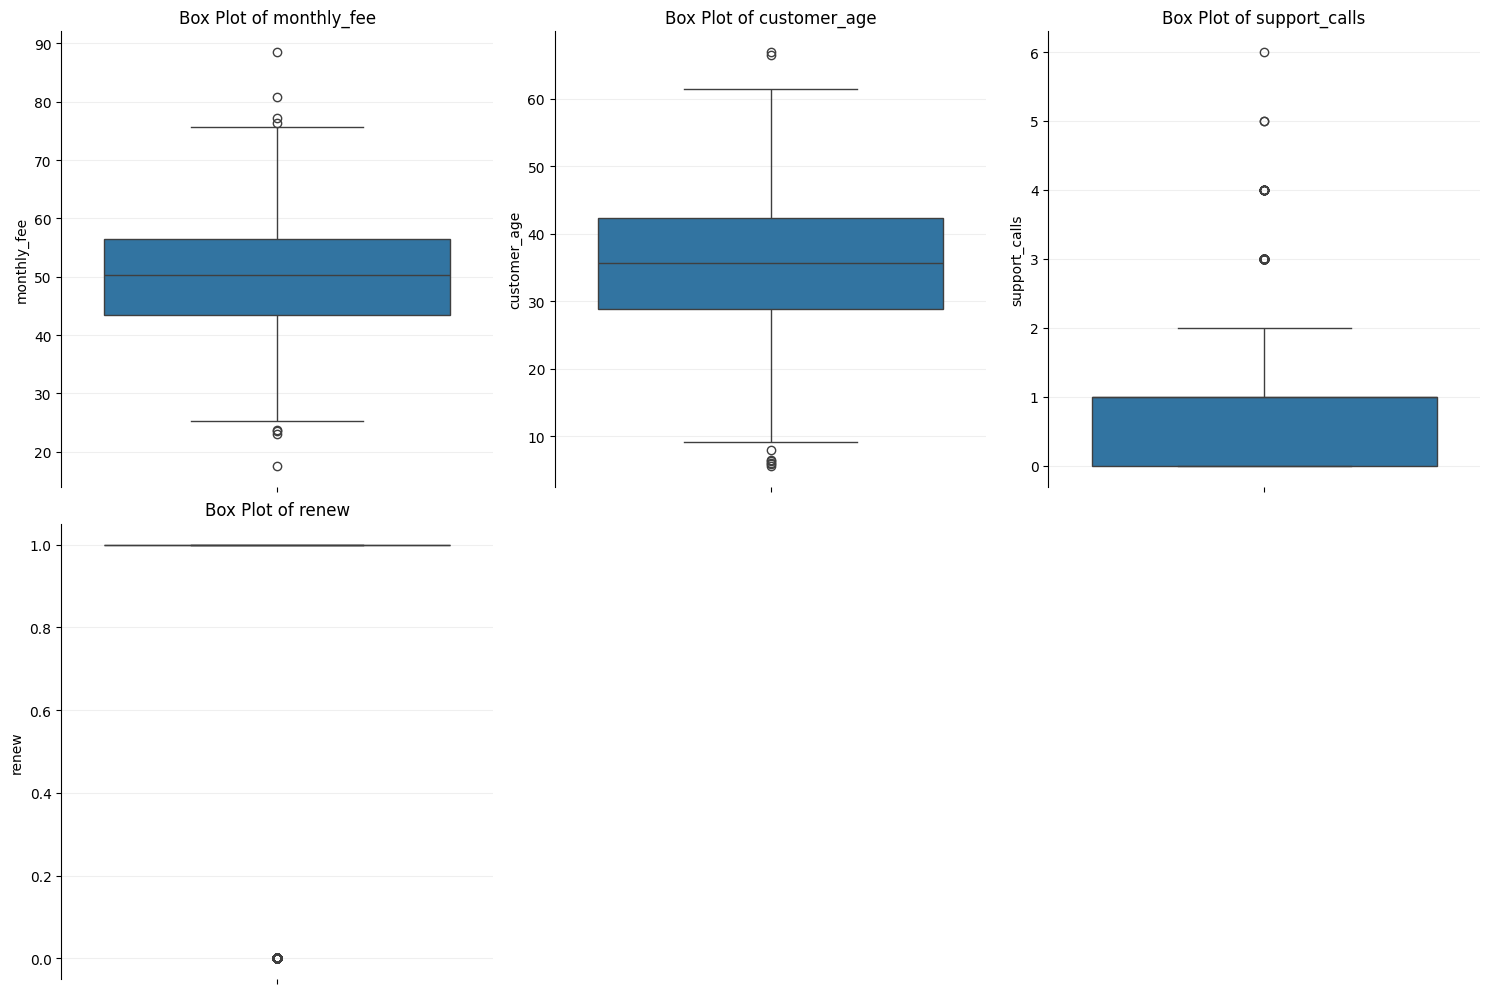

In [12]:
n_cols = 3
n_rows = (len(numeric_cols) // n_cols) + (1 if len(numeric_cols) % n_cols else 0)

plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=subscription_churn_data, y=col)
    sns.despine(right=True, top=True, bottom=True)
    plt.title(f'Box Plot of {col}')
    plt.grid(axis='y', alpha=0.2)
    plt.grid(axis='x', visible=False)
plt.tight_layout()
plt.show()

#### Missing data plot

- This visualization helps to quickly identify which columns have missing values and the extent of the missing data. The heatmap will show yellow for missing values and purple for present values, making it easy to spot patterns of missingness. This is useful for understanding the completeness of the dataset and deciding how to handle missing values in subsequent analysis.
- The code uses `Seaborn`'s `heatmap()` function to visualize missing data in the DataFrame.
- The code also uses the `isnull()` method to create a boolean DataFrame indicating where values are missing (True) or present (False).
- `yticklabels=False` hides the y-axis labels to reduce clutter and increase the data-to-ink ratio.
- `cbar=False` removes the color bar, which is not necessary for this plot.
- `cmap='viridis'` sets the color map to 'viridis' which is a perceptually uniform color map suitable for visualizing missing data; yellow represents missing values, while purple represents present values.
- `plt.title('Missing Data')` sets the title of the plot to 'Missing Data'
- `plt.show()` displays the plot.

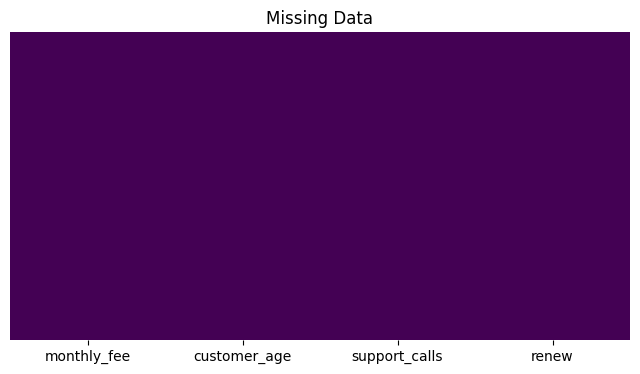

In [13]:
plt.figure(figsize=(8, 4))
sns.heatmap(subscription_churn_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Data')
plt.show()

#### Correlation heatmap

- This visualization helps to quickly identify relationships between numeric features. The heatmap will show the strength and direction of correlations, with colors indicating positive (red) or negative (blue) correlations. This is useful for understanding how features relate to each other and can inform feature selection or feature engineering in subsequent analysis.
- The code uses `Searborn`'s `heatmap()` function to visualize the Spearman correlation matrix of the numeric features in the DataFrame.
- `annot=True` adds the correlation values as annotations on the heatmap.
- `cmap='coolwarm'` sets the color map to 'coolwarm' which provides a gradient from blue (negative correlation) to red (positive correlation).
- `center=0` centers the color map at 0, which is useful for visualizing both positive and negative correlations.

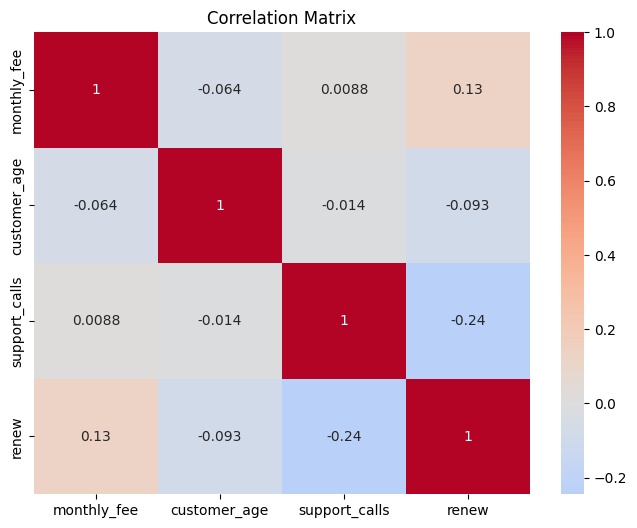

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

#### Scatter plot matrix

- This visualization helps to quickly identify relationships between pairs of numeric features. The scatter plot matrix will show scatter plots for each pair of numeric features, allowing for visual inspection of relationships, trends, and potential outliers. This is useful for understanding how features interact with each other and can inform feature selection or feature engineering in subsequent analysis.
- The code uses `Seaborn`'s `pairplot()` function to create a scatter plot matrix of the numeric features in the DataFrame
- `plt.suptitle('Scatter Plot Matrix', y=1.02)` Adds a centered title above all subplots (or the single plot). `y=1.02` Moves the title upward by 2% of the figure height (default is y=1.0). This is done to prevent overlap in the subplot titles.

<Figure size 1000x1000 with 0 Axes>

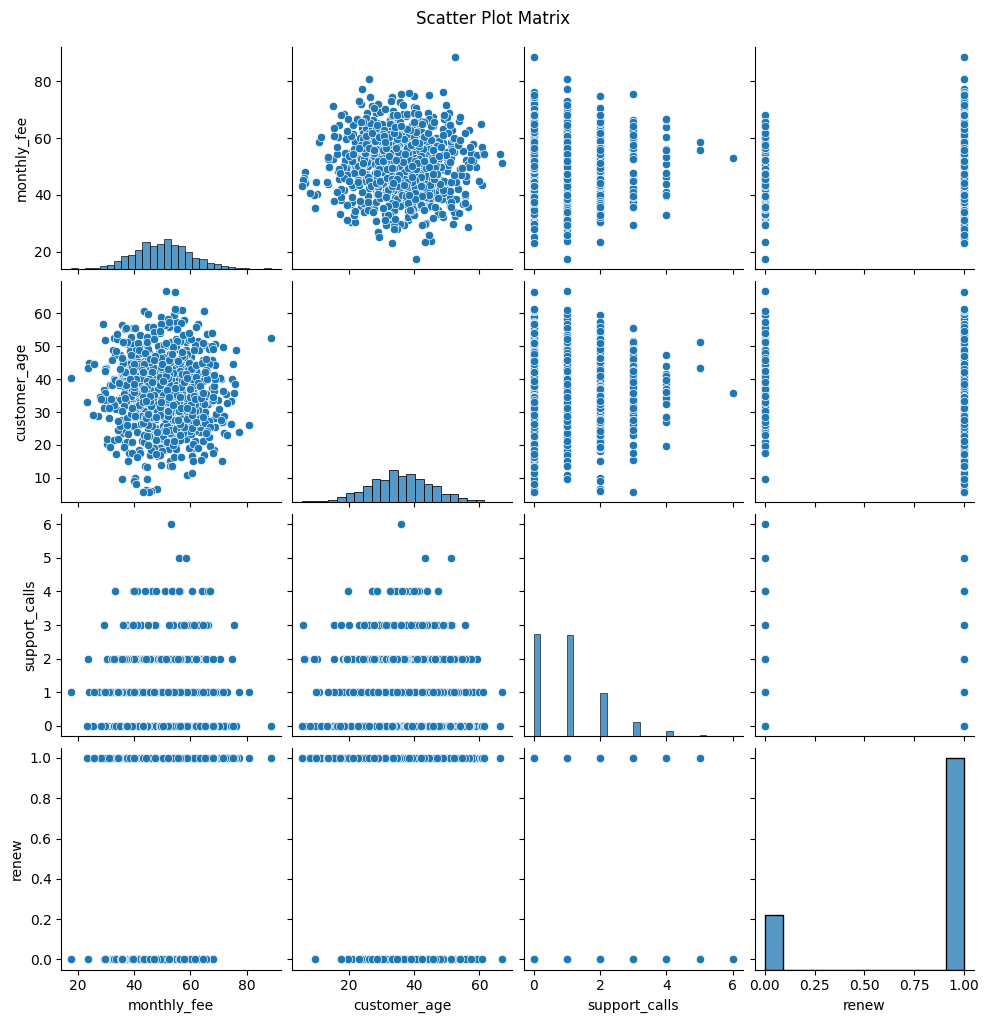

In [15]:
plt.figure(figsize=(10, 10))
sns.pairplot(subscription_churn_data[numeric_cols])
plt.suptitle('Scatter Plot Matrix', y=1.02)
plt.show()

## Step 4: Data preprocessing and transformation

### Create X and y datasets for the features and target variable respectively

`X = ...`
* Separates the data such that the data frame called `X` contains only the features (independent variables or predictors)

`y = ...`
* Separates the data such that the data frame called `y` contains only the target (dependent variable or outcome)

In [16]:
X = subscription_churn_data[['monthly_fee','customer_age','support_calls']]
y = subscription_churn_data['renew']

print("\nThe number of observations and variables in the features dataset")
print(X.shape)
print("\nThe columns in the features dataset")
print(X.columns)

print("\nThe number of observations and variables in the target dataset")
print(y.shape)


The number of observations and variables in the features dataset
(1000, 3)

The columns in the features dataset
Index(['monthly_fee', 'customer_age', 'support_calls'], dtype='object')

The number of observations and variables in the target dataset
(1000,)


### Train‑test split

- This step splits the dataset into training and testing sets to evaluate the model's performance on unseen data. The `train_test_split()` function is used to randomly split the data, ensuring that the target variable's distribution is preserved in both sets.
- `stratify=y` in train_test_split ensures that the train and test sets have the same proportion of each class label as the original dataset. This is important for classification tasks, especially when classes are imbalanced, as it preserves the class distribution in both splits.
- `test_size=0.3` indicates that 30% of the data will be used for testing, while 70% will be used for training.
- `random_state=53` ensures reproducibility of the split, meaning that every time you run the code, you will get the same split of data.
- `StandardScaler()` is used to standardize the features by setting mean = 0 and variance = 1. This is important for kNN, as it is sensitive to the scale of the features. Standardization ensures that all features contribute equally to the distance calculations.
- `fit_transform()` is applied to the training data to compute the mean and standard deviation, and then transform the data accordingly.
- `transform()` is applied to the test data using the same scaler fitted on the training data. This ensures that the test data is scaled in the same way as the training data, preventing data leakage.

- The `train_test_split` function returns four objects:
  - `X_train`: features for training
  - `X_test`: features for testing
  - `y_train`: labels for training
  - `y_test`: labels for testing

**Why:** Splitting the data this way allows you to train your model on one part of the data and evaluate its performance on unseen data, which helps prevent overfitting and gives an objective measure of the model's accuracy.

*Analogy:* This is similar to how a student learning a subject is not exposed to only one past paper that they can memorize. If they memorize the past paper and the exam assesses them on a different set of questions, then their performance in the exam will not be the same as their performance in the memorized past paper.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=53, stratify=y)

## Step 5: Design the decision tree model

- `model = DecisionTreeClassifier(criterion="gini", random_state=53)`
  - This creates an instance of a decision tree classifier using the CART algorithm.
  - **criterion="gini"**: Specifies that the tree should use the Gini impurity measure to decide how to form the splits in the tree.
  - **random_state=53**: Ensures reproducibility by setting the random seed.

- `model.fit(X_train, y_train)`
  - This trains (fits) the decision tree classifier on the training data (`X_train` for features, `y_train` for the target).
  - This step therefore builds the decision tree model so it can learn patterns from the training data and later make predictions on new, unseen data.

In [18]:
# Using Gini impurity by default
decisiontree_classifier = DecisionTreeClassifier(
    criterion="gini",
    random_state=53,
    max_depth=4)
decisiontree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=53)

## Step 6: Evaluate the Model

`y_pred = decisiontree_classifier.predict(X_test)`

- This uses the trained decision tree classifier (`decisiontree_classifier`) to predict the labels for the test set features (`X_test`). This gives you the model’s predictions on data it has not seen before, which is necessary for evaluating its performance.

`print('The decision tree model\'s performance metrics:\n', classification_report(y_test, y_pred))`
- This prints a detailed classification report comparing the true labels (`y_test`) to the predicted labels (`y_pred`). The report includes precision, recall, F1-score, and support for each class, enabling you to understand how well the model performs.
- It shows the performance metrics for a model that predicts two classes:
    - Class 0
    - Class 1

- There are 300 items tested:
    - Class 0 has 56 items
    - Class 1 has 244 items

| Term             | Meaning                                                                                                                             |
|------------------|-------------------------------------------------------------------------------------------------------------------------------------|
| **Precision**    | Out of all items the model said are class X, how many are actually class X?                                                         |
| **Recall**       | Out of all actual items in class X, how many did the model correctly find?                                                          |
| **F1-score**     | A balance between precision and recall such  that a higher value means better balance.                                              |
| **Support**      | The number of actual items in that class.                                                                                           |
| **Macro avg**    | The average of precision, recall, and F1-score for both classes, treating them equally.                                             |
| **Weighted avg** | The average of precision, recall, and F1-score, but weighted by how many samples are in each class (so class 1 has more influence). |

- The results show that the model is much better at predicting class 1 than class 0, and overall gets **82%** of predictions correct. This may be because there are more class 1 cases in the data.
- It is an example of a model that is biased towards the majority class (class 1) and may not perform well in the minority class (class 0). This is a common issue in classification problems, especially when the **classes are imbalanced**.

In [19]:
y_pred = decisiontree_classifier.predict(X_test)

print('The model\'s performance metrics:\n', classification_report(y_test, y_pred))

The model's performance metrics:
               precision    recall  f1-score   support

           0       0.50      0.26      0.34        62
           1       0.83      0.93      0.88       238

    accuracy                           0.79       300
   macro avg       0.66      0.60      0.61       300
weighted avg       0.76      0.79      0.77       300



## Step 7: Visualize the Decision Tree

`plt.figure(figsize=(12, 8))`
- This creates a new matplotlib figure with a size of 12 inches by 8 inches to ensure that the decision tree plot is large and readable.

`plot_tree(...)`
- Plots the trained decision tree (`decisiontree_classifier`).
    - `feature_names=['monthly_fee','customer_age','support_calls']`: Labels the tree’s nodes with the feature names.
    - `class_names= ['Cancel', 'Renew']`: Labels the leaves with the class names.
    - `filled=True`: Colors the nodes based on the class for better visualization.
    - `fontsize=8`: Sets the font size for the text in the plot to 8 for better readability.
    - `max_depth=4`: Limits the depth of the tree to 4 levels for better readability.
- This visually shows how the decision tree splits the data and makes decisions.

`plt.title("A Decision Tree Classifier using Gini Impurity (CART)")`
- Sets the title of the plot to provide context for the visualization.

`plt.show()`
- This is used to display the plot in the notebook.

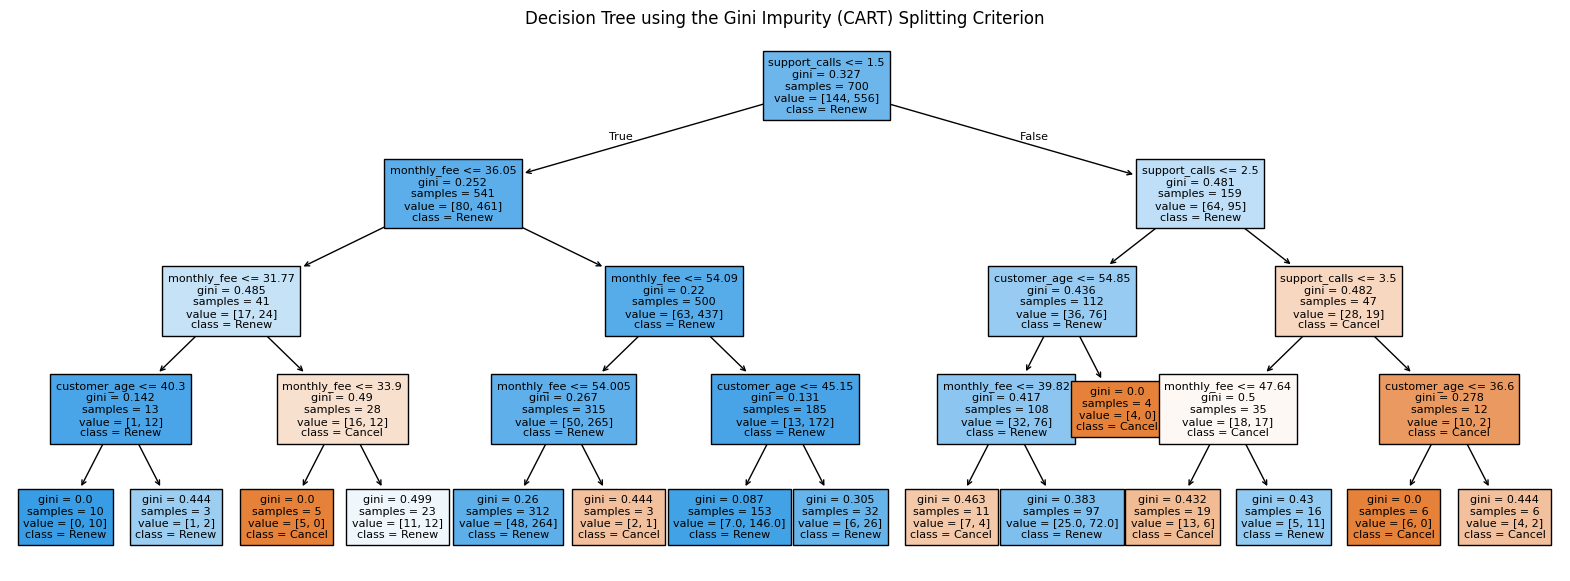

In [20]:
plt.figure(figsize=(20, 7))
plot_tree(
    decisiontree_classifier,
    feature_names=['monthly_fee','customer_age','support_calls'],
    class_names= ['Cancel', 'Renew'],
    filled=True,
    fontsize=8,
    max_depth=4)
plt.title("Decision Tree using the Gini Impurity (CART) Splitting Criterion")
plt.show()

## Step 8: Make predictions on new data and save the results for reporting in Power BI

In [21]:
# Example: Using the trained model to make predictions on new or unseen data.
# Create a DataFrame with new customer data (replace values as needed)
new_data = pd.DataFrame({
    'monthly_fee': [50, 80],
    'customer_age': [25, 40],
    'support_calls': [2, 0]
})

# Predict whether the customers will renew or cancel their subscription
predictions = decisiontree_classifier.predict(new_data)
print("Predictions for new data:", predictions)

label_map = {0: 'Cancel', 1: 'Renew'}
predicted_labels = [label_map[p] for p in predictions]
print("Predicted labels for new data:", predicted_labels)

Predictions for new data: [1 1]
Predicted labels for new data: ['Renew', 'Renew']


- This section demonstrates how to use the trained decision tree model to make predictions on new data and save the results for reporting in Power BI.
- It loads new data, processes it similarly to the training data, makes predictions, and saves the results to a CSV file for further analysis or reporting.
- The new data is expected to have the same structure as the training data, with the same features used for training the model.
- The predictions include whether the customers are likely to renew or cancel their subscription, along with the probabilities of each outcome.
- The results are saved to a CSV file, which can then be imported into Power BI for visualization and reporting.
- This is useful for businesses to understand customer behavior and make informed decisions based on the model's predictions.

In [22]:
dataset_path = './data/subscription_churn_new_data.csv'
url = 'https://github.com/course-files/RegressionAndClassification/raw/refs/heads/main/data/subscription_churn_new_data.csv'

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    if not os.path.exists('./data'):
        os.makedirs('./data')
    urllib.request.urlretrieve(url, dataset_path)
    print("✅ Dataset downloaded")
else:
    print("✅ Dataset already exists locally")

use_cols = ['monthly_fee','customer_age','support_calls']
new_data = pd.read_csv(dataset_path, usecols=use_cols, encoding='utf-8', nrows=200000)


# Make predictions
predictions = decisiontree_classifier.predict(new_data)
probabilities = decisiontree_classifier.predict_proba(new_data)

# Add predictions and probabilities to the original dataframe
new_data['Renew_Probability_Class_0'] = probabilities[:, 0]  # Probability of cancellation
new_data['Renew_Probability_Class_1'] = probabilities[:, 1]  # Probability of renewal
new_data['Predicted_Renew'] = predictions

print("\nThe new data with predictions:")
display(new_data)


✅ Dataset downloaded

The new data with predictions:


,monthly_fee,customer_age,support_calls,Renew_Probability_Class_0,Renew_Probability_Class_1,Predicted_Renew
0,51.11,39.4,0,0.153846,0.846154,1
1,38.49,35.4,1,0.153846,0.846154,1
2,53.76,36.2,1,0.153846,0.846154,1
3,43.99,41.1,0,0.153846,0.846154,1
4,47.08,24.8,1,0.153846,0.846154,1
5,43.98,32.4,0,0.153846,0.846154,1
6,68.52,18.3,1,0.045752,0.954248,1
7,49.87,39.0,1,0.153846,0.846154,1
8,39.42,41.5,0,0.153846,0.846154,1
9,58.23,30.2,1,0.045752,0.954248,1


## Step 9: Export the results for further analysis and reporting using a tool like Power BI

- A `.pkl` file in Python is a file that stores serialized Python objects using the **pickle** library (for small models) or the **joblib** library (for models created using `scikit-learn`).
- It is created through a process called **pickling**, which converts a Python object (like a trained machine learning model) into a byte stream that can be saved to a file.
- This allows you to save the state of an object so that it can be restored later without needing to retrain the model or recreate the object from scratch.
- In the context of machine learning, a `.pkl` file is often used to save trained models so that they can be reused later without needing to retrain them. This is particularly useful for deploying models in production or sharing them with others.
- The `.pkl` file contains the serialized state of the model, including its parameters, learned weights, and configuration. When you load a `.pkl` file, you can restore the model to its previous state and use it to make predictions on new data without needing to retrain it.

### Save the predictions to a CSV file for reporting and the model to a `.pkl` file for deployment

In [25]:
# Save the results as a CSV file for further analysis and reporting
output_path = './data/subscription_churn_predicted_data.csv'
# Ensure the data directory exists
if not os.path.exists('./data'):
    os.makedirs('./data')
# Save the CSV file regardless of environment (Google Colab or local)
new_data.to_csv(output_path, index=False)
print(f"\n✅ Results saved to {output_path}")

# Provide a download link if running in Google Colab
try:
    from google.colab import files
    files.download(output_path)
except ImportError:
    print("❌ Not running in Google Colab, skipped dataset download link.")

# Save the model
model_path = './model/decisiontree_classifier_baseline.pkl'
# Ensure the model directory exists
if not os.path.exists('./model'):
    os.makedirs('./model')
# Save the model regardless of environment (Google Colab or local)
joblib.dump(decisiontree_classifier, model_path)
print(f"✅ Model saved to {model_path}")

# Provide a download link if running in Google Colab
try:
    from google.colab import files
    files.download(model_path)
except ImportError:
    print("❌ Not running in Google Colab, skipped model download link.")


✅ Results saved to ./data/subscription_churn_predicted_data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model saved to ./model/decisiontree_classifier_baseline.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Confirm that you can load the saved model and make predictions on new data

In [24]:
import joblib
import pandas as pd

# Load the saved model
model_path = './model/decisiontree_classifier_baseline.pkl'
loaded_model = joblib.load(model_path)

# Load new data for prediction
new_data = pd.DataFrame({
    'monthly_fee': [60, 90],
    'customer_age': [30, 50],
    'support_calls': [1, 3]
})

# Predict whether the customers will renew or cancel their subscription
predictions = loaded_model.predict(new_data)
print("Predictions for new data:", predictions)

label_map = {0: 'Cancel', 1: 'Renew'}
predicted_labels = [label_map[p] for p in predictions]
print("Predicted labels for new data:", predicted_labels)

Predictions for new data: [1 1]
Predicted labels for new data: ['Renew', 'Renew']


# Business Insights
- The model's predictions can be used to identify customers who are likely to churn, allowing the marketing and sales teams to take proactive measures to retain them.
- The predictions and probabilities for new customer data have been saved to a CSV file, which can be imported into Power BI for reporting.
- The decision tree visualization provides insights into the key features that influence customer churn. These include monthly fee, customer age, and support calls.
- The model's accuracy can be further improved by tuning hyperparameters, using more advanced algorithms, or incorporating additional features.